<a href="https://colab.research.google.com/github/Gaeli75/Deep-Learning-Pratices-1/blob/main/DP_learning_week_5_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lightning-utilities


In [3]:
!pip install torchmetrics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 45.7 MB/s eta 0:00:00


Importing important

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

In [5]:
device = "cuda" if torch.cuda.is_available()\
     else "mps" if torch.mps.is_available()\
     else "cpu"
print("device", device)

device cuda


In [6]:
#Importing Data for Training Data
train_data = torchvision.datasets.CIFAR10( root = './data', train = True,
    transform = ToTensor(),
    download = True,
)

100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [30]:
Classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Changed Classes to integers
num_class = len(Classes)

In [32]:
sample_images = []
for class_i in range(num_class):
  # Get the indices of samples belonging to the current class
  indices = np.where(np.array(train_data.targets) == class_i)[0]

  # Check if there are any samples for this class
  if len(indices) > 0:
    # If yes, get the first sample
    sample_image = train_data.data[indices[0]]
    sample_images.append(sample_image)
  else:
    # If no samples for this class, print a message or handle it appropriately
    print(f"No samples found for class {class_i}")

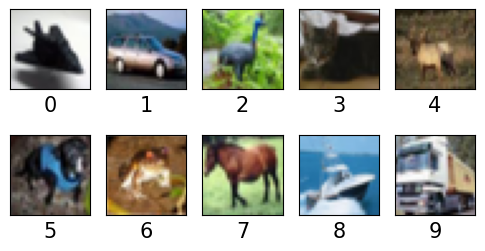

In [35]:
#show images
fig, axes = plt.subplots(2,5,  figsize = (6,3))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(Classes[i], fontsize = 15)
    axis.imshow(sample_images[i], cmap = 'gray')
    i += 1

In [7]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data = torchvision.datasets.CIFAR10( root = './data', train = False,
    transform = ToTensor(),
    download = True,
)

Files already downloaded and verified


In [9]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_set, val_set = torch.utils.data.random_split(train_data, [0.8, 0.2])

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [12]:
model = nn.Sequential(
    nn.LazyConv2d(32, kernel_size=3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.LazyConv2d(64, kernel_size=3, stride =1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)

In [13]:
model = model.to(device)

In [14]:
criterian = torch.nn.CrossEntropyLoss()


In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [16]:
#Training Model
def train_one_epoch():
    #preparing the data
    losses = MeanMetric().to(device)
    acc  = Accuracy(task = 'multiclass', num_classes = 10).to(device)
    model.train()
    #Loop for the model
    for X, Y in train_dataloader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterian(pred, Y)
        loss.backward()
        optimizer.step()
        preds = pred.argmax(dim = 1)
        losses.update(loss.item(), X.size(0)) # Changed loss.X.size(0) to loss.item(), X.size(0)
        acc.update(preds, Y) # Changed pred to preds, as preds contains the predicted labels

    return losses.compute().item(), acc.compute().item()


In [17]:
#Validation Model
def Validation_one_epoch():
    #preparing the data
    losses = MeanMetric().to(device)
    acc  = Accuracy(task = 'multiclass', num_classes = 10).to(device)
    model.eval()
    #Loop for the model
    for X, Y in val_dataloader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterian(pred, Y)
        loss.backward()
        optimizer.step()
        preds = pred.argmax(dim = 1)
        losses.update(loss.item(), X.size(0)) # Changed loss.X.size(0) to loss.item(), X.size(0)
        acc.update(preds, Y) # Changed pred to preds, as preds contains the predicted labels

    return losses.compute().item(), acc.compute().item()

In [22]:
epochs = 28
for i in range(0, epochs):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = Validation_one_epoch()
    print("Epoch: ", i, "| Train Loss: ", train_loss, "| Train Accuracy", train_acc, "| Val Loss: ", val_loss, "| Val Accuracy: ", val_acc)

Epoch:  0 | Train Loss:  0.0020920410752296448 | Train Accuracy 0.9999250173568726 | Val Loss:  0.0023978950921446085 | Val Accuracy:  0.9998000264167786
Epoch:  1 | Train Loss:  0.0025241775438189507 | Train Accuracy 0.999750018119812 | Val Loss:  0.0020487490110099316 | Val Accuracy:  1.0
Epoch:  2 | Train Loss:  0.002005890943109989 | Train Accuracy 0.999875009059906 | Val Loss:  0.0019400716992095113 | Val Accuracy:  0.9998999834060669
Epoch:  3 | Train Loss:  0.0018548741936683655 | Train Accuracy 0.9999250173568726 | Val Loss:  0.001978588290512562 | Val Accuracy:  0.9998000264167786
Epoch:  4 | Train Loss:  0.001802694285288453 | Train Accuracy 0.999875009059906 | Val Loss:  0.0019068334950134158 | Val Accuracy:  0.9998999834060669
Epoch:  5 | Train Loss:  0.0016562084201723337 | Train Accuracy 0.9999250173568726 | Val Loss:  0.0016061898786574602 | Val Accuracy:  1.0
Epoch:  6 | Train Loss:  0.001534763490781188 | Train Accuracy 0.9999250173568726 | Val Loss:  0.001515153795480

In [23]:
#Storing Evaluation metrics
test_confusion_matrix = ConfusionMatrix(task = 'multiclass', num_classes = 10).to(device) # Moved the confusion matrix to the device
test_accuracy = Accuracy(task = 'multiclass', num_classes = 10).to(device) # Moved the accuracy metric to the device

In [24]:
model = model.to(device)
model.eval()
with torch.no_grad():
    for X, Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        preds = pred.argmax(dim = 1)
        test_confusion_matrix.update(pred, Y)
        test_accuracy.update(pred, Y)
print("Confusion Matrix: \n", test_confusion_matrix.compute())
print("Accuracy: ", test_accuracy.compute().item())

Confusion Matrix: 
 tensor([[762,  17,  44,  22,  22,   8,  18,  12,  56,  39],
        [ 33, 763,  10,  17,   7,   4,  14,   6,  28, 118],
        [ 78,   6, 574,  72,  83,  57,  68,  36,  11,  15],
        [ 22,  13,  74, 515,  65, 170,  77,  35,   9,  20],
        [ 25,   6,  99,  70, 605,  39,  62,  73,  14,   7],
        [ 22,   3,  62, 175,  54, 572,  41,  56,   7,   8],
        [ 11,   9,  40,  53,  44,  32, 788,   6,  10,   7],
        [ 28,   8,  36,  52,  69,  56,  13, 716,   4,  18],
        [ 66,  43,  20,  19,  12,   9,   8,   2, 788,  33],
        [ 35,  96,  18,  25,   6,  14,  10,  18,  34, 744]], device='cuda:0')
Accuracy:  0.682699978351593


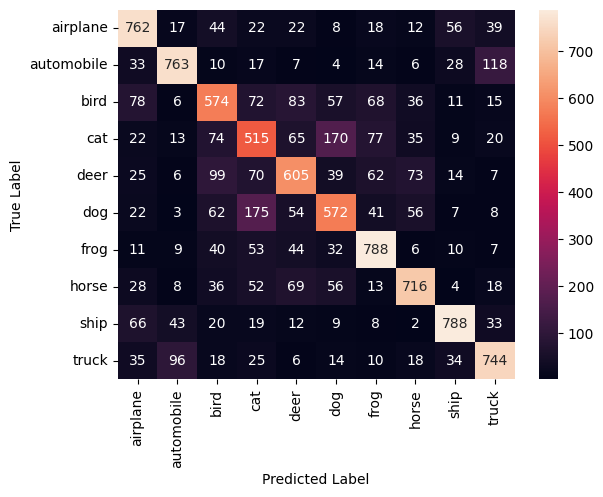

In [26]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(test_confusion_matrix.compute().cpu().numpy(), annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()